# Calculates EOF of MOC

In [2]:
#load packages
import numpy as np
from netCDF4 import Dataset
import cPickle as pickle
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
%matplotlib inline
mpl.rc('font',size=16) #set default font size and weight for plots

In [3]:
#user defined inputs
datdir1 = '/Users/Karen/Dropbox/CESM/python/CESM/'
var = 'MOC'
fileend = '.allyrs.ATL.nc'
month = ['11', '12', '01', '02', '03','04','05','06','07','08','09','10','11','12']

#open netcdf files
varnames = dict()
for i in range(len(month)):
    fname1        = var + '.monthly.' + month[i] + fileend
    nc1           = Dataset(fname1)
    varnames_tmp1 = np.squeeze(nc1.variables[var][:,:,:])
    varnames[i] = np.ma.masked_greater(varnames_tmp1,1e20)
    
    z             = nc1.variables['moc_z'][:]
    lat           = nc1.variables['lat_aux_grid'][:]

In [4]:
var_ssws = np.stack((varnames[0][0:varnames[0].shape[0]-1,:,:],varnames[1][0:varnames[0].shape[0]-1,:,:],
                     varnames[2][1:varnames[0].shape[0],:,:],varnames[3][1:varnames[0].shape[0],:,:],
                     varnames[4][1:varnames[0].shape[0],:,:],varnames[5][1:varnames[0].shape[0],:,:],
                     varnames[6][1:varnames[0].shape[0],:,:],varnames[7][1:varnames[0].shape[0],:,:],
                     varnames[8][1:varnames[0].shape[0],:,:],varnames[9][1:varnames[0].shape[0],:,:],
                     varnames[10][1:varnames[0].shape[0],:,:],varnames[11][1:varnames[0].shape[0],:,:],
                     varnames[12][1:varnames[0].shape[0],:,:],varnames[13][1:varnames[0].shape[0],:,:]))

In [5]:
ssta = np.ma.MaskedArray.anom(var_ssws,axis=1)

In [6]:
ssta_jfm = signal.detrend(np.mean(ssta[2:5,:,:,:],axis=0),axis=0) #average over JFM
ssta_ann = signal.detrend(np.mean(ssta[2:14,:,:,:],axis=0),axis=0) #Annual mean

In [7]:
lat[94]

0.0

In [8]:
#cosine-weight
cos_tmp = np.cos((lat*np.pi/180.0))
cos_tmp[301] = 0
cos_wgt = np.real(np.sqrt(cos_tmp))

var_eof_jfm = np.ma.zeros((ssta_jfm.shape[0],ssta_jfm.shape[1],ssta_jfm.shape[2]))
for i in range(ssta_jfm.shape[0]):
    for j in range(ssta_jfm.shape[1]):
        var_eof_jfm[i,j,:] = cos_wgt*ssta_jfm[i,j,:]
        
var_eof_ann = np.ma.zeros((ssta_ann.shape[0],ssta_ann.shape[1],ssta_ann.shape[2]))
for i in range(ssta_ann.shape[0]):
    for j in range(ssta_ann.shape[1]):
        var_eof_ann[i,j,:] = cos_wgt*ssta_ann[i,j,:]

In [9]:
#var_eof_jfm = var_eof_jfm[:,:,94:]

In [10]:
var_eof_jfm.shape

(1100, 61, 302)

In [11]:
# reshape the array to have one time dimension, one space dimension (Ny = latitude, Nx = longitude, Nt = time)
Nt, Ny, Nx = var_eof_jfm.shape
print Nt, Ny, Nx
var_eof_jfm.shape = (Nt, Ny*Nx)

1100 61 302


In [12]:
#perform svd analysis (note: u and v are normalized such that, e.g., u.T * u = I)
u, s, v = np.linalg.svd(var_eof_jfm.T, full_matrices=False)
print u.shape, v.shape, s.shape
S = np.diag(s)

# reshape spatial pattern
moc_pat = np.reshape(u, (Ny,Nx,Nt))
moc_pat.shape

(18422, 1100) (1100, 1100) (1100,)


(61, 302, 1100)

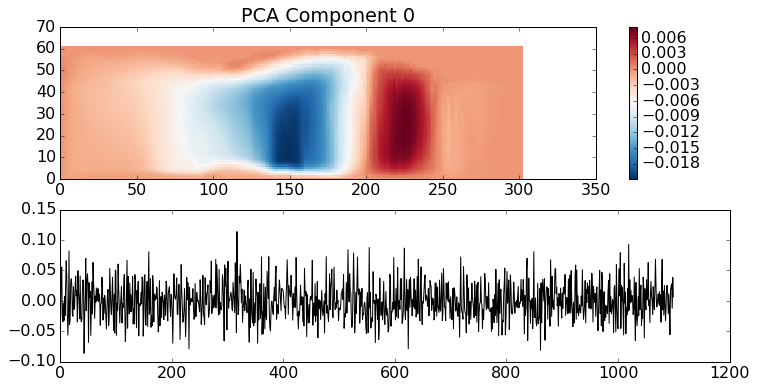

In [13]:
# look at first eof pattern and pc time series
for n in range(1):
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    pc = plt.pcolormesh(moc_pat[:,:,n], cmap='RdBu_r')
    plt.title('PCA Component %g' % n)
    cbar = plt.colorbar(pc)
    #plt.clim([-0.1,0.1])
    #plt.yticks(np.arange(0,38,5.4),['20','30','40','50','60','70','80','90'])
    #plt.xticks(np.arange(0,49,8),['90W','60W','30W','0','30E','60E','90E'])
    plt.subplot(212)
    plt.plot(np.arange(0,var_eof_jfm.shape[0],1), v[n,:],'k')

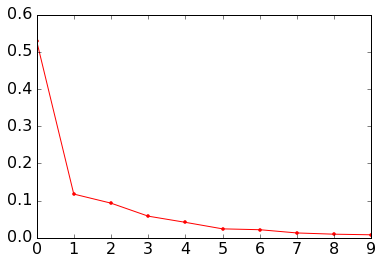

In [14]:
# variance explained by first 10 components
L = s*s.T / v.shape[1] #convert s to eigenvalues (lambda = ss.T/N)
plt.plot(L[:10] / L.sum(),'.-',color='r')

In [15]:
L[:10] / L.sum()

array([ 0.52990077,  0.11755814,  0.09316165,  0.05819209,  0.04157483,
        0.02404916,  0.02174917,  0.01303218,  0.00970465,  0.00808708])

In [16]:
#re-normalize PC time series (because we are using a correlation matrix instead of a covariance matrix)
pc_ts = v * np.sqrt(Nt) #now in units of standard deviation

In [17]:
#project eof onto SLP anomaly amplitude (in hPa)
moc_pca = (u * s)/np.sqrt(Nt)
# reshape spatial pattern
moc_pat_anom = np.reshape(moc_pca, (Ny,Nx,Nt))

In [18]:
lat.shape

(302,)

In [19]:
xx, yy = np.meshgrid(lat,z/100000)

In [23]:
#pickle for plotting
pname = 'MOC_JFM_EOF_plot.pickle'
with open(pname,'wb') as fp:
    pickle.dump([xx,yy,moc_pat_anom],fp)

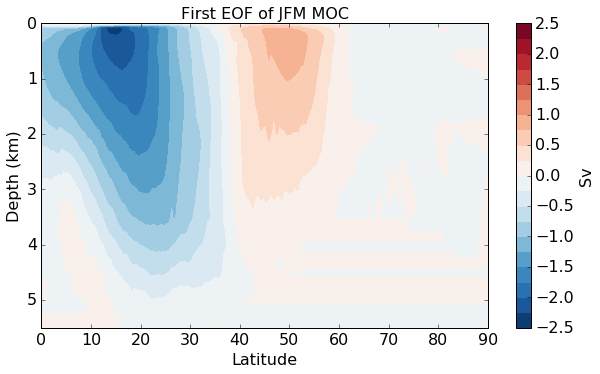

In [20]:
# look at first eof pattern and pc time series
fig = plt.figure(figsize=(10,12))
v = np.linspace(-2.5,2.5,21)
v2 = np.linspace(-2.5,2.5,11)
for n in range(1):
    ax1 = fig.add_subplot(2,1,1)
    pc = plt.contourf(xx,yy,moc_pat_anom[:,:,n],v,cmap='RdBu_r')
    plt.title('First EOF of JFM MOC',fontsize=16)
    plt.xlabel('Latitude',fontsize=16,)
    plt.ylabel('Depth (km)',fontsize=16)
    plt.gca().invert_yaxis()
    #add colorbar
    cbar = fig.colorbar(pc)
    cbar.set_label('Sv', fontsize=16)
    cbar.set_ticks(v2,update_ticks=True)
    cbar.ax.tick_params(labelsize=16)
    #plt.clim([-5,5])
    plt.xlim(0,90)
#save figure
#plt.savefig('MOC_JFM_EOF.eps',bbox_inches='tight')

(array([  10.,   46.,  151.,  280.,  270.,  194.,  102.,   37.,    9.,    1.]),
 array([-2.85226778, -2.18946317, -1.52665856, -0.86385395, -0.20104934,
         0.46175527,  1.12455988,  1.78736449,  2.4501691 ,  3.11297371,
         3.77577832]),
 <a list of 10 Patch objects>)

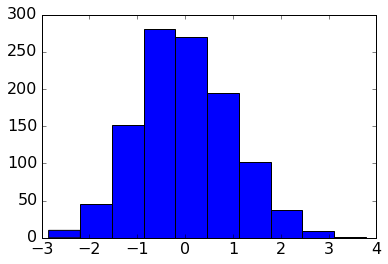

In [21]:
plt.hist(pc_ts[0,:])

In [22]:
##create daily NAO time series by regressing onto EOF pattern
#Nyr, Nt, Ny, Nx = var_dec_anom_cw.shape
#nao_dec_daily = np.zeros((Nyr,Nt))
#tmp = np.squeeze(var_dec_anom_cw)
#tmp.shape = (Nyr, Nt, Ny*Nx)
#nao_dec_daily = np.dot(tmp, np.sqrt(Nyr)*u[:,0]/s[0]) #only first EOF (in units of std because we divide by s/N^(0.5))

In [38]:
#pickle DJFM NAO 
pname = 'MOC_JFM_all_rev.pickle'
with open(pname,'wb') as fp:
    pickle.dump([pc_ts[0,:]],fp)